In [26]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score

# Define some convenient functions to plot model results

In [27]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [28]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [29]:
def iris_classifier(df, independant_var, model_name, model):
    """Fit a classifer defined in model based on independant_var

    Parameters
    ----------
    df: dataset
    independant_var: list of independant variable (length 2)
    model_name: name of the model to be displayed in the title
    model: sklearn classifier
    """
    
    model.fit(df[independant_var], df['target'])
    X0, X1 = df[independant_var[0]], df[independant_var[1]]
    xx, yy = make_meshgrid(X0, X1)
    y=df['target']
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    plot_contours(ax[0], model, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax[0].scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax[0].set_xlim(xx.min(), xx.max())
    ax[0].set_ylim(yy.min(), yy.max())
    ax[0].set_xlabel(independant_var[0])
    ax[0].set_ylabel(independant_var[1])
    ax[0].set_xticks(())
    ax[0].set_yticks(())
    
    plot_confusion_matrix(model, df[independant_var], df['target'],
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, ax=ax[1])
    
    plt.subplots_adjust(wspace=0.5)
    
    precision = precision_score(df['target'], model.predict(df[independant_var]), average='macro')
    recall = recall_score(df['target'], model.predict(df[independant_var]), average='macro')
    
    fig.suptitle('{}\nprecision={:.2f} recall = {:.2f}'.format(model_name, precision, recall))

# Import data

In [30]:
# import some data to play with
iris = datasets.load_iris()

In [31]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [32]:
print(iris.feature_names)
print(iris.target_names)
class_names = iris.target_names

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [33]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Define and analyse classification models
Several models are tested and analyzed in the following manner:
 - define 2 independant variables
 - fit the model that learns how to recognize an iris based on the 2 independant variables
 - qualitative analysis:
     - plot the decision boundaries on a 2d plot
 - quantitative analysis:
     - plot the confusion matrix = predicted label vs true label
     - display 2 scores:
         - precision = tp / (tp + fp) --> ability of the classifier not to label as positive a sample that is negative
         - recall = tp / (tp + fn) --> ability of the classifier to find all the positive samples

In [34]:
models = {
    'Naive Bayes': GaussianNB(),
    'linear SVC': LinearSVC(C=1, max_iter=10000),
    'SVC with linear kernel': SVC(kernel='linear', C=1),
    'SVC with polynomial kernel': SVC(kernel='poly', degree=3, gamma='auto', C=1),
    'SVC with rbf kernel': SVC(kernel='rbf', gamma=0.7, C=1),
    'KNN uniform weight': KNeighborsClassifier(20, weights='uniform'),
    'KNN distance weight': KNeighborsClassifier(20, weights='distance'),
    'decision tree depth 1': DecisionTreeClassifier(max_depth=1, min_samples_split=4, min_samples_leaf=4),
    'decision tree depth 2': DecisionTreeClassifier(max_depth=2, min_samples_split=4, min_samples_leaf=4),
    'decision tree depth 3': DecisionTreeClassifier(max_depth=3, min_samples_split=4, min_samples_leaf=4),
    'gaussian process': GaussianProcessClassifier(kernel=RBF())   
}

/Users/thomas/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


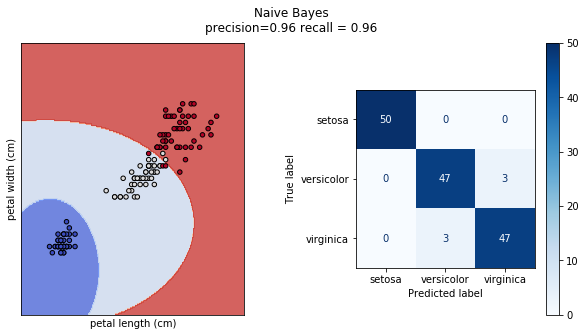

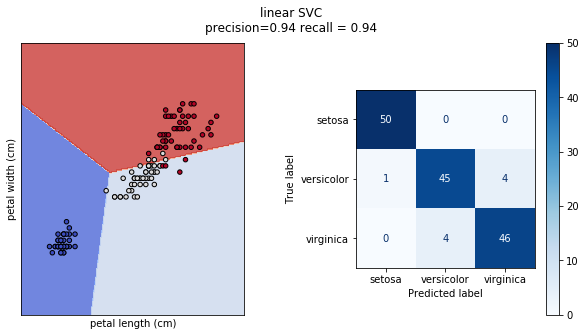

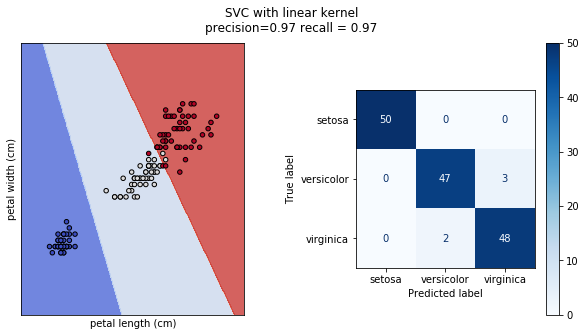

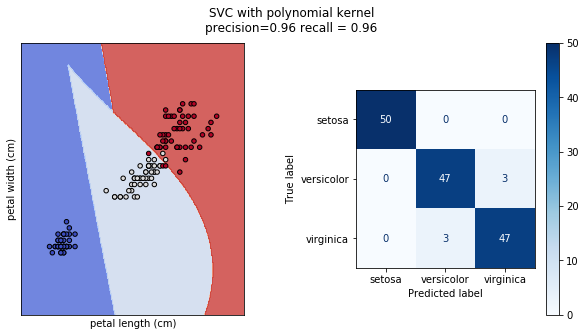

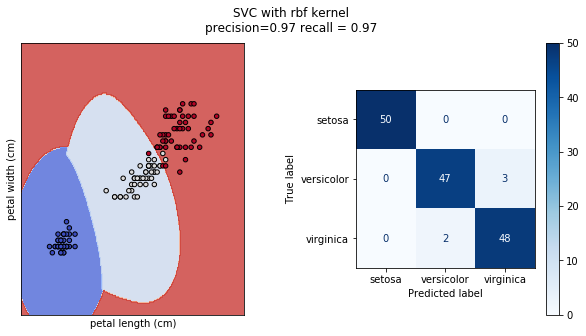

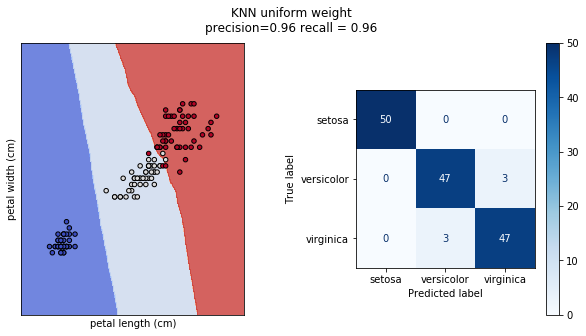

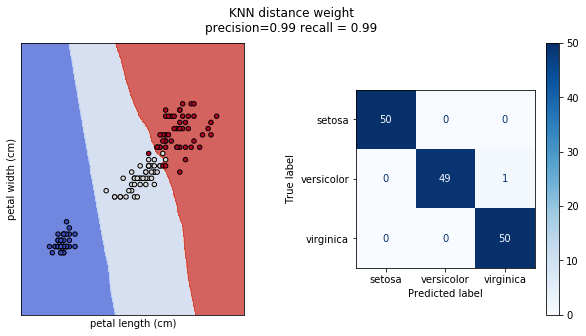

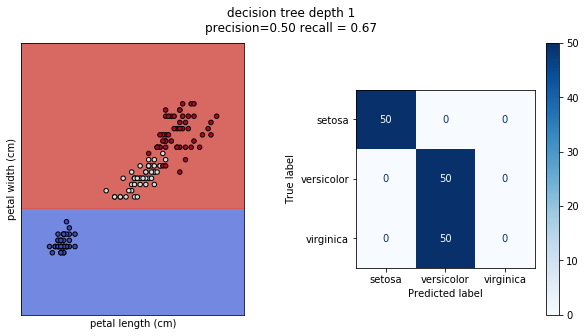

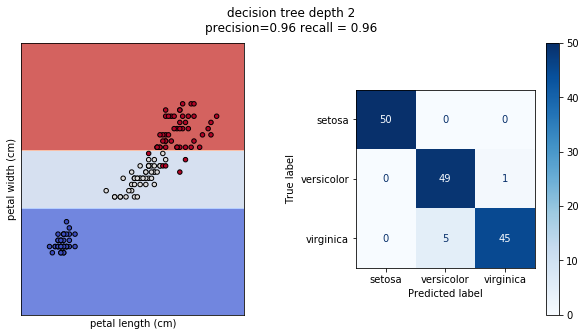

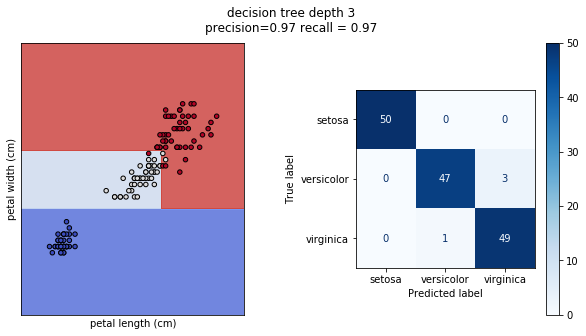

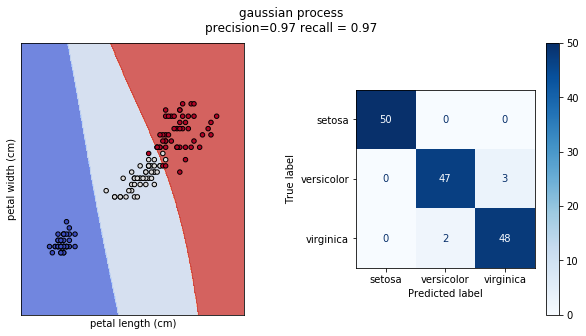

In [37]:
independant_var = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

randomlist = random.sample(range(0, len(independant_var)), len(independant_var))
independant_var2 = []
for i in randomlist:
    independant_var2.append(independant_var[i])
    
for key, item in models.items():
    iris_classifier(df, independant_var2[:2], key, item)

# Clustering
As opposed to classification, clustering is a non supervised task, ie it does not require a dependant variable. The aim of clustering is to gather the data in groups based on their features.<br>
https://www.groupe-hli.com/machine-learning-dans-industrie/

In [11]:
from sklearn.cluster import KMeans
independant_var = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
k_means = KMeans(n_clusters=3)
k_means.fit(df[independant_var])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0.5, 1.0, 'cluster')

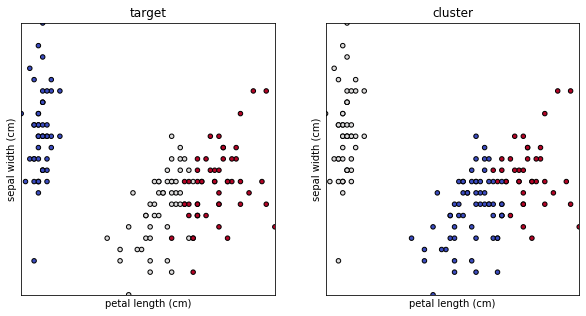

In [12]:
randomlist = random.sample(range(0, len(independant_var)), len(independant_var))
independant_var2 = []
for i in randomlist:
    independant_var2.append(independant_var[i])

df['cluster'] = k_means.labels_
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(df[independant_var2[0]], df[independant_var2[1]], c=df['target'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax[0].set_xlim(df[independant_var2[0]].min(), df[independant_var2[0]].max())
ax[0].set_ylim(df[independant_var2[1]].min(), df[independant_var2[1]].max())
ax[0].set_xlabel(independant_var2[0])
ax[0].set_ylabel(independant_var2[1])
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_title('target')

ax[1].scatter(df[independant_var2[0]], df[independant_var2[1]], c=df['cluster'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax[1].set_xlim(df[independant_var2[0]].min(), df[independant_var2[0]].max())
ax[1].set_ylim(df[independant_var2[1]].min(), df[independant_var2[1]].max())
ax[1].set_xlabel(independant_var2[0])
ax[1].set_ylabel(independant_var2[1])
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_title('cluster')